# Predicting End user Quality Of Experience based on WiFi KPIs

## 1. Introduction
Wifi has been the go to connectivity network for the users, smart devices within a home environment. Devices in homes are increasingly connected, generating higher network traffic and requiring exponentially higher bandwidth, lower latency and reliability. End users are demanding more of these applications as applications like AR/VR, cloud gaming, streaming, video conferncing are being adopted at a faster pace. End users are more and more interested in over-all user experience than factors like internet speed etc.

Internet Operators are reaching out to end customers with more emphasis on user experience because of the shift in end user apetite. Hence there is an increased focus within operator community about end user's Quality Of Experience, besides the network QoS and KPIs. 

Our focus with this experimentation is about how end user quality of experience vary with respect to WiFi metrics. And our goals is to evaluate multiple ML/AI models in predicting end user Quality of Experience based the real-time WiFi and application metrics data.

## 2. Experimentation overview
The goal of the setup is to simulate a home environment, where a device can be at different distances from the AP and multiple devices connect to AP and contend for the air interface. Setup simulates the varying distance from the AP by having 3 separate chambers each hosting a virtual AP and these three chambers are stationed at near, medium and far distance from the device under test chamber.

In each chamber we instantiate x number of virtual STAs. We start with 1 virtual STA and increase the number of active virtual STAs one by one until 8. Each virtual STA send 30Mbps traffic upstream, down stream and both direction traffic.  Each time we run a cloud gaming application using automated testing system that can simulate different application bandwidths 10, 30, 50 Mbps. This automated platform also can capture the application QoE metrics.


## 3. Data overview

At each run of the test, candella LanForge system captures two separate files: port_metrics.csv & vap_metrics.csv. Port Metrics file consists of the stats collected at virtual AP in the Lanforge system and the metrics are the system metrics. VAP metrics file contains the metrics for each virtual STA as well as device under test STA.

Application management system collects the application metrics and these metrics are captured in Qoe.xslx file.

Here are the list of metrics in each file.

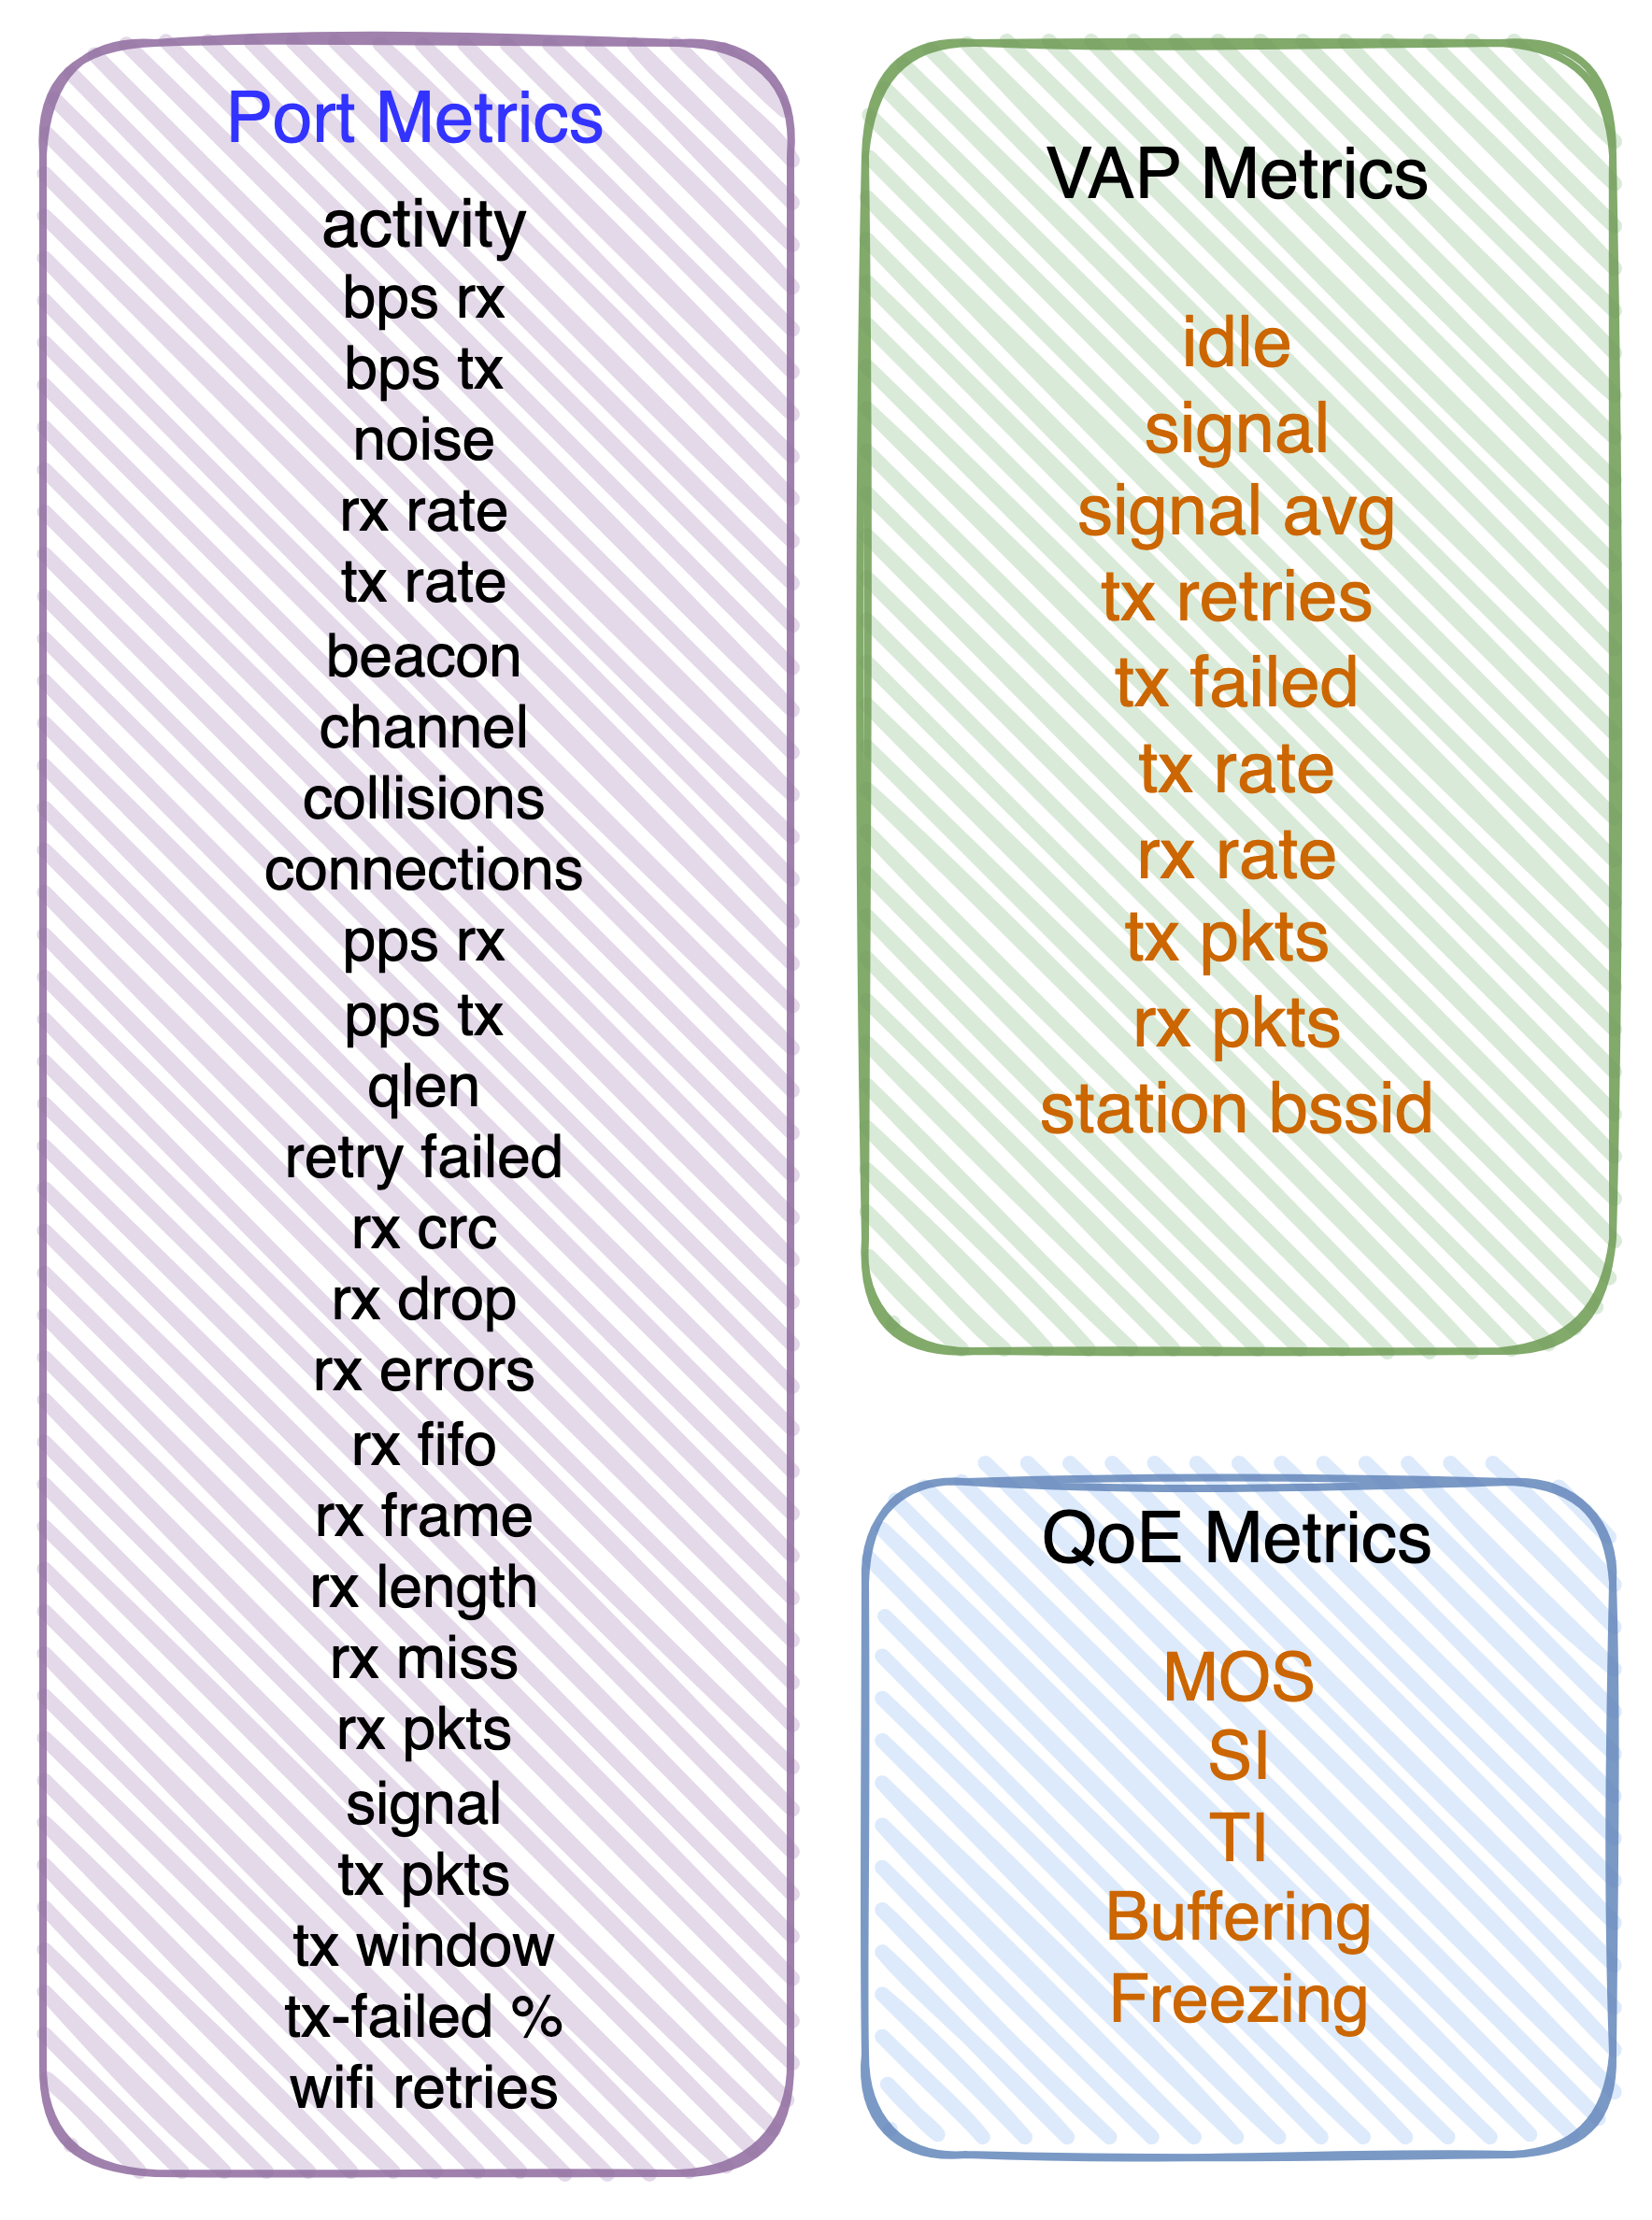

In [1]:
import sys
!{sys.executable} -m pip install openpyxl


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.1.5/libexec/bin/python -m pip install --upgrade pip


In [19]:
import os
import re
import time
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from scipy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.compose import ColumnTransformer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings('ignore')

## Data pre-processing
Data collected from candella and Usemetrics are organized based on how we run testing and collect the data accordingly. This test was about how a user playing a cloud gaming application running on connected device experience the game based on near-realistic scenarios in a home.  A home WiFi environment consists of multiple devices connected to AP and contending for the channel. And also that devices connected to AP in a home environment could be at different distances from AP, like some devices could be near to the AP while the other at far from AP.

So, our testing includes multiple virtual Stations connected to AP along with device under test (STA). We tested device under test stationed at 3 different locations in our test: near to AP, at medium distance from AP and Far from AP. We also tested the device under test to compete for channel access with a varying number of virtual stations: one vSTA, two vSTAs and so far until 8 vSTAs. We also tested the application with different speeds: 10/30/50 Mbps.

Metrics collected both at candella and Usemetrics are done for all the combinations of these three varations: distance from AP, number of vSTAs and throughput. Each test is condusted for one minute, client uses WiFi to connect to AP and the we start the cloud game to connect to the server in the cloud and we run the test for a minute and disconnect.

The purpose of this data analysis project is to evaluate the models and find the model that predicts the MOS scores based on WiFi metrics most accurately. This function trains and validates a model and return trained model and the time it took to train the data. It takes the regression pipeline and prameter grid as input.

This method is a composite function that goes through three regression models: Linear Regression, Ridge and Lasso Regression and evaluates these models with respect to their accuracy.

This method measures absolute error and percentage of error between predicted MOS scores vs actual MOS score (in Test data).  It takes regression pipe line along with training and test WiFi metrics and MOS scores as input. It plots histogram plot of error and percentage error distribution along with axvlines that depict mean, 2 * STD, -2 * STD values in that bin. This function returns mean error, mean percentage error, standard deviation of error and standard deviation of percentage error.

In [20]:
def parse_port_metrics(file):
    datagram = pd.read_csv(file)
    cols = ['activity', 'noise', 'rx-rate', 'tx-rate', 'beacon', 'bps rx',
            'bps rx ll', 'bps tx', 'bps tx ll', 'channel', 'collisions', 'connections', 'pps rx', 'pps tx', 'qlen', 'retry failed', 'rx crc',
        'rx drop', 'rx errors', 'rx fifo', 'rx frame', 'rx length', 'rx miss', 'rx pkts', 'signal', 'tx pkts',
        'rx over', 'tx abort', 'tx crr', 'tx errors', 'tx fifo', 'tx hb',
        'tx wind', 'tx-failed %', 'wifi retries', 'timestamp']
    df = datagram.loc[:, cols]
    df['db'] = df['noise'].str.extract('(^[-+]?\d+)').astype(float)
    df['sig'] = df['signal'].str.extract('(^[-+]?\d+)').astype(float)
    df['rxrate'] = df['rx-rate'].str.extract('(^[-+]?\d+)').astype(float)
    df['txrate'] = df['tx-rate'].str.extract('(^[-+]?\d+)').astype(float)
    df = df.drop(['noise', 'rx-rate', 'tx-rate', 'signal'], axis = 1)
    return df

In [21]:
def parse_vap_metrics(file):
    data = pd.read_csv(file)
    col_map = {'idle': 'sta_idle', 'signal': 'sta_signal', 'signal avg': 'sta_signal_avg',
               'tx retries': 'sta_tx_retries', 'tx-failed': 'sta_tx_failed'}
    cols = ['idle', 'rx rate', 'signal', 'signal avg', 'tx rate', 'tx retries', 'tx-failed', 'tx pkts', 'rx pkts', 'station bssid', 'timestamp']
    df = data.loc[:, cols]
    df.rename(columns = col_map, inplace = True)
    df['sta_rx_rate'] = df['rx rate'].str.extract('(^[-+]?\d+)').astype(float)
    df['sta_tx_rate'] = df['tx rate'].str.extract('(^[-+]?\d+)').astype(float)
    df['sta_tx_pkts'] = df['tx pkts']
    df['sta_rx_pkts'] = df['rx pkts']
    df['sta_bssid'] = df['station bssid']
    df = df.drop(['rx rate', 'tx rate', 'tx pkts', 'rx pkts', 'station bssid'], axis = 1)
    return df

In [22]:
def custom_round(value):
    # Round up to one decimal point
    rounded_value = np.ceil(value * 10) / 10
    # Check if first decimal is less than 5, set it to 0
    if (rounded_value * 10) % 10 <= 5:
        return np.floor(rounded_value)
    else:
        return np.floor(rounded_value) + 0.5

In [23]:
def parse_port_vap_metrics(base):
    dataframes = dict()
    for root, dirs, files in os.walk(base):
        pf = 'port_metrics.csv' in files
        vf = 'vap_metrics.csv' in files
        qf = 'Qoe.xlsx' in files

        # If CSV files exist in the current directory
        row_repeat = 11
        if pf and vf and qf:
            pm_df = parse_port_metrics(os.path.join(root, 'port_metrics.csv')).sort_values(by = 'timestamp', ascending = True)
            vm_df = parse_vap_metrics(os.path.join(root, 'vap_metrics.csv')).sort_values(by = 'timestamp', ascending = True)

            splits = root.split('/')
            vm_df['direction'] = splits[3]
            vm_df['distance'] = splits[5]
            vm_df['sta_bw'] = int(re.search(r'^\d+', splits[6]).group()) if re.search(r'^\d+', splits[6]) is not None else 0
            vm_df['stas'] = int(re.search(r'^\d+', splits[7]).group()) if re.search(r'^\d+', splits[7]) is not None else 0

            repeated_rows = []
            for idx, value in enumerate(vm_df.groupby('timestamp')['sta_bssid'].count()):
                repeated_row = pd.DataFrame(np.repeat(pm_df.iloc[[idx]], value, axis = 0), columns = pm_df.columns)
                repeated_rows.append(repeated_row)

            pm_r = pd.concat(repeated_rows, ignore_index=True).drop('timestamp', axis = 1)
            #print(f"## PM DF concated shape: {pm_r.shape} ##")
            
            merged_df = pd.merge(pm_r, vm_df, left_index=True, right_index=True)
            #print(f"## Merged DF shape {merged_df.shape} ##")
            sorted_df = merged_df.sort_values(by='timestamp', ascending = True)

            qoe_xlsx = pd.read_excel(os.path.join(root, 'Qoe.xlsx'), sheet_name = 'Raw Data 1')
            qoe_n = qoe_xlsx.loc[:, ['TimeStamp', 'MOS', 'SI', 'TI']]
            qoe_n['ts'] = qoe_n['TimeStamp'].apply(custom_round)

            qoe_n['MOS_R'] = qoe_n['MOS'].round(1)
            qoe_n.drop(['TimeStamp', 'MOS'], axis = 1, inplace = True)
            qoe_n.rename(columns = {'MOS_R': 'MOS'}, inplace = True)

            if qoe_n.groupby('ts')['MOS'].count()[0] >= 120:
                qoe = qoe_n.query('ts >= 1 and ts <= 62')
            else:
                qoe = qoe_n.copy()

            df =  merge_qoe_df(sorted_df, qoe)
            if df is not None:
                dataframes[root] = df

    return dataframes

In [24]:
def merge_qoe_df(port_df, qoe_df):
    ts_count = port_df.groupby('timestamp')['stas'].count().shape[0]
    if all(col in qoe_df.columns for col in ['MOS', 'SI', 'TI']):
        grouped_qoe = qoe_df.groupby('ts')[['MOS', 'SI', 'TI']].mean().round(1).reset_index()
        #grouped_qoe.rename(columns = {'ts': 'timestamp'}, inplace = True)
        #print(grouped_qoe.shape, ts_count)
        if grouped_qoe.shape[0] > ts_count:
            merge_qoe = grouped_qoe.iloc[: int(ts_count - grouped_qoe.shape[0])]
        elif grouped_qoe.shape[0] < ts_count:
            return None
        else:
            merge_qoe = grouped_qoe.copy()

        # Empty list to store the repeated rows
        repeated_rows = []
        # Iterate through the Series and df_left
        for idx, value in enumerate(port_df.groupby('timestamp')['stas'].count()):
            # Repeat the row value times
            repeated_row = pd.DataFrame(np.repeat(merge_qoe.iloc[[idx]], value, axis = 0), columns = merge_qoe.columns)
            repeated_rows.append(repeated_row)

        # Concatenate all the repeated rows
        qoe_repeated = pd.concat(repeated_rows, ignore_index=True)
        #print(f"# QoE concated shape {qoe_repeated.shape} #")
        # Merge the repeated left DataFrame with the right DataFrame
        df_merged = pd.merge(port_df, qoe_repeated, left_index=True, right_index=True)
        #print(f"# Merged QoE DF shape {df_merged.shape} #")

    # vSTAs with RX rate less than or equal to 6.0 are dummy vSTAs, so drop those rows.
    return df_merged.query('sta_rx_rate > 6.0')

In [25]:
def get_correlation (df):
    # Compute the correlation matrix
    corr_matrix = df.select_dtypes(include=['number']).corr()

    # Unstack the correlation matrix into a DataFrame of column pairs
    corr_pairs = corr_matrix.unstack()

    # Drop the diagonal elements (correlation of a column with itself)
    corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

    # Sort the pairs by absolute correlation value in descending order
    return corr_pairs.abs().sort_values(ascending=False)

In [26]:
def train_and_validate_model(pipe, params, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(pipe, param_grid= params, cv=5)

    # Fit GridSearchCV to the training data
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    duration = time.time() - start_time

    print(f'## Classifier: {grid_search.best_estimator_.named_steps['regressor']} Training Report ##')
    print("Training time: ", duration, "seconds")
    print("Best Parameters: ", grid_search.best_params_)
    print("Best training Accuracy:", grid_search.best_score_)

    # Test the model on the test set
    test_score = grid_search.score(X_test, y_test)
    print("Test Set Accuracy:", test_score)

    return grid_search, duration

In [27]:
def validate_models(X_train, X_test, y_train, y_test):
  # Define MSE scorer
  mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

  # Define models to compare
  models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
  }

  # Define parameter grids for each model
  param_grids = {
    'LinearRegression': {
        'poly__degree': [1, 2],
        'regressor__fit_intercept': [True, False]
    },
    'Ridge': {
        'poly__degree': [1, 2],
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__fit_intercept': [True, False]
    },
    'Lasso': {
        'poly__degree': [1, 2],
        'regressor__alpha': [0.1, 0.5, 1.0],
        'regressor__fit_intercept': [True, False]
    }
  }

  # Loop over models and parameter grids
  results = []
  for model_name, model in models.items():
    print(f"\nRunning GridSearchCV for {model_name}...")

    # Define a pipeline with StandardScaler, PolynomialFeatures, and the model
    pipeline = Pipeline([
        ('poly', PolynomialFeatures()),      # Polynomial features
        ('regressor', model)                 # Regression model (will vary)
    ])

    # Set up GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring=mse_scorer, return_train_score=True)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train.ravel())

    # Store results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['model'] = model_name  # Add model name to results
    results.append(cv_results)

  # Concatenate all results for comparison
  results_df = pd.concat(results, ignore_index=True)

  # Select important columns for comparison
  comparison_columns = [
    'model', 'param_poly__degree', 'param_regressor__fit_intercept', 'param_regressor__alpha',
    'mean_test_score', 'std_test_score', 'mean_train_score'
  ]

  # Display the results sorted by mean test score (MSE)
  #print("\nComparison of MSE between different models:")
  #print(results_df[comparison_columns].sort_values(by='mean_test_score',       ascending=True))
  return results_df

In [28]:
def plot_erro_dist(grid, X_train, X_test, y_train, y_test):
    best_nf = grid.best_estimator_
    X_df = pd.concat([pd.DataFrame({'predict': best_nf.predict(X_test), 'actual': y_test, 'tag': "test"}),
                      pd.DataFrame({'predict': best_nf.predict(X_train), 'actual': y_train, 'tag': "train"})])
    X_df = X_df.assign(
        error = lambda x: abs(x['predict'] - x['actual']),
        p_error = lambda x: x['error'].div(x['actual'])
    )
    
    # Compute Errors Metrics.
    error_mean = X_df.query('tag == "test"')['error'].mean()
    error_std = X_df.query('tag == "test"')['error'].std()
    print(f"error mean = {error_mean: 0.2f}, error std = {error_std: 0.2f}")
    p_error_mean = X_df.query('tag == "test"')['p_error'].mean()
    p_error_std = X_df.query('tag == "test"')['p_error'].std()
    print(f"p_error mean = {p_error_mean: 0.2%}, p_error std = {p_error_std: 0.2%}")
    mape = X_df['p_error'].abs().mean()
    wape = X_df['error'].abs().sum() / X_df['actual'].abs().sum()

    try:
        # Define plot grid.
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
        sns.set_style(
            style='darkgrid',
            rc={'axes.facecolor': '.9', 'grid.color': '.8'}
        )
        sns.set_palette(palette='deep')
        sns_c = sns.color_palette(palette='deep')
    
        # Add data.
        sns.histplot(data=X_df['error'], bins=100, color=sns_c[0], kde=True, ax=axs[0])
        axs[0].axvline(x=error_mean, color=sns_c[0], linestyle='--', label=f'error mean = {error_mean: 0.2f}', alpha=0.8)
        axs[0].axvline(x=error_mean + 2*error_std, color=sns_c[0], linestyle='--', alpha=0.5)
        axs[0].axvline(x=error_mean - 2*error_std, color=sns_c[0], linestyle='--', alpha=0.5)
    
        sns.histplot(data=X_df['p_error'], bins = 100, color=sns_c[3], kde=True, ax=axs[1])
        axs[1].axvline(x=p_error_mean , color=sns_c[3], linestyle='--', label=f'p_error mean = {p_error_mean: 0.2%}', alpha=0.8)
        axs[1].axvline(x=p_error_mean + 2*p_error_std, color=sns_c[3], linestyle='--', alpha=0.5)
        axs[1].axvline(x=p_error_mean - 2*p_error_std, color=sns_c[3], linestyle='--', alpha=0.5)
    
        axs[0].set(title='Absolute')
        axs[1].set(title='Percentage')
        plt.suptitle(f'Linear Model Errors Distribution', y=0.94);
    
        # Adjust layout for better spacing
        plt.tight_layout()
    
        # Show the plots
        plt.show()
    except Exception as e:
        # Catch the exception and print detailed information
        print(f"An error occurred: {e}")  # Print the error message
        print(f"Exception type: {type(e).__name__}")  # Print the type of the exception
        return error_mean, p_error_mean, error_std, p_error_std
        
    return error_mean, p_error_mean, error_std, p_error_std
    

In [29]:
def plot_correlation_matrix (df):
    plt.figure(figsize=(12, 10))  # Set the figure size
    sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
    #sns.heatmap(df.corr(), cmap=sns.cubehelix_palette(as_cmap=True))
    #sns.heatmap(corr_matrix, cmap='crest')

    # Add a title
    plt.title('Correlation Heatmap')

    # Show the plot
    plt.show()

In [30]:
def plot_kpis(data):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    sns.scatterplot(data=data.query('`wifi retries` < 200000'), x='wifi retries', y='activity', ax=axes[0, 0])
    axes[0, 0].set_title('Scatter: WiFi Retries vs WiFi Utilization')

    bins = pd.cut(data.query('`wifi retries` < 200000')['wifi retries'], bins=3, labels=['Low', 'Medium', 'High'])
    sns.scatterplot(data=data.query('`wifi retries` < 200000'), x='wifi retries', y='activity', hue = bins, ax=axes[0, 1])
    axes[0, 1].set_title('Scatter: WiFi Retries vs activity (with low-high bins)')

    grouped_activity = data.groupby('activity', as_index=False)['MOS'].mean()
    sns.lineplot(data=grouped_activity, x='activity', y='MOS', ax = axes[1,0])
    #sns.scatterplot(data = data, x = 'activity', y = 'MOS_x', ax = axes[1,0])
    axes[1, 0].set_title('Scatter: WiFi activity vs MOS Score')

    filtered_data = data.query('`wifi retries` < 25000')
    filtered_data['retries'] = pd.cut(filtered_data['wifi retries'], bins=10, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    grouped_retry = filtered_data.groupby('retries', observed=True)['MOS'].mean().reset_index()
    sns.lineplot(data = grouped_retry, x = 'retries', y = 'MOS', marker='o', ax = axes[1,1])
    axes[1, 1].set_title('Scatter: WiFi retries vs MOS Score')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

In [8]:
metrics_map = parse_port_vap_metrics('./data/Test')
metrics_map['./data/Test/downlink-uplink/30mbps_down_up/Near/10Mbps/3vsta/Run1'].head(5)

,activity,beacon,bps rx,bps rx ll,bps tx,bps tx ll,channel,collisions,connections,pps rx,...,sta_rx_pkts,sta_bssid,direction,distance,sta_bw,stas,ts,MOS,SI,TI
3,0.0,0.0,826993.0,826993.0,4702137.0,4702137.0,36.0,0.0,0.0,106.0,...,47,78:2b:46:3b:0c:3f,downlink-uplink,Near,10,3,0.0,4.4,83.0,42.7
12,0.0,0.0,7246.0,7246.0,4637.0,4637.0,36.0,0.0,0.0,7.0,...,47,78:2b:46:3b:0c:3f,downlink-uplink,Near,10,3,0.5,4.6,82.2,35.1
21,0.0,0.0,906.0,906.0,2284.0,2284.0,36.0,0.0,0.0,0.0,...,47,78:2b:46:3b:0c:3f,downlink-uplink,Near,10,3,1.0,4.5,82.0,24.7
30,0.0,0.0,729.0,729.0,1531.0,1531.0,36.0,0.0,0.0,0.0,...,47,78:2b:46:3b:0c:3f,downlink-uplink,Near,10,3,1.5,4.4,84.0,38.4
39,0.0,0.0,503.0,503.0,1057.0,1057.0,36.0,0.0,0.0,0.0,...,47,78:2b:46:3b:0c:3f,downlink-uplink,Near,10,3,2.0,4.5,87.4,24.9


In [9]:
df = pd.concat(metrics_map.values(), ignore_index=True)
df.shape

(98513, 54)

In [10]:
df.head()

,activity,beacon,bps rx,bps rx ll,bps tx,bps tx ll,channel,collisions,connections,pps rx,...,sta_rx_pkts,sta_bssid,direction,distance,sta_bw,stas,ts,MOS,SI,TI
0,0.0,0.0,39431.0,39431.0,5029.0,5029.0,36.0,0.0,0.0,9.0,...,7387037,28:c2:1f:f9:f6:16,downlink-uplink,Medium,10,2,6.0,4.2,88.2,31.6
1,0.0,0.0,3002561.0,3002561.0,3801498.0,3801498.0,36.0,0.0,0.0,271.0,...,2355537,9c:fc:e8:f6:6e:9d,downlink-uplink,Medium,10,2,7.0,4.3,86.6,36.3
2,0.0,0.0,3002561.0,3002561.0,3801498.0,3801498.0,36.0,0.0,0.0,271.0,...,11456510,6c:6a:77:16:bc:54,downlink-uplink,Medium,10,2,7.0,4.3,86.6,36.3
3,2.0,0.0,6247990.0,6247990.0,8152568.0,8152568.0,36.0,0.0,0.0,553.0,...,2358811,9c:fc:e8:f6:6e:9d,downlink-uplink,Medium,10,2,7.5,4.5,83.0,37.6
4,2.0,0.0,6247990.0,6247990.0,8152568.0,8152568.0,36.0,0.0,0.0,553.0,...,11461890,6c:6a:77:16:bc:54,downlink-uplink,Medium,10,2,7.5,4.5,83.0,37.6


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98513 entries, 0 to 98512
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   activity        98513 non-null  float64
 1   beacon          98513 non-null  float64
 2   bps rx          98513 non-null  float64
 3   bps rx ll       98513 non-null  float64
 4   bps tx          98513 non-null  float64
 5   bps tx ll       98513 non-null  float64
 6   channel         98513 non-null  float64
 7   collisions      98513 non-null  float64
 8   connections     98513 non-null  float64
 9   pps rx          98513 non-null  float64
 10  pps tx          98513 non-null  float64
 11  qlen            98513 non-null  float64
 12  retry failed    98513 non-null  float64
 13  rx crc          98513 non-null  float64
 14  rx drop         98513 non-null  float64
 15  rx errors       98513 non-null  float64
 16  rx fifo         98513 non-null  float64
 17  rx frame        98513 non-null 

Make sure that all the rows are unique for 'Station BSSID' and 'Time Stamp' combination.

In [12]:
is_unique = not df.duplicated(subset=['sta_bssid', 'timestamp']).any()
is_unique

True

# Understanding the data
A simple pre-processing step that can be done before data preparation is to understand the data and find the correlation between different features and explore the relation between the input data.

## MOS Score distribution
When choosing random data for trainining, validation and testing, we need to make sure that selected data follows the same distribution pattern as that how MOS scores are distributed. Hence here we find the MOS score distribution pattern and plot it as histogram as well as a pie chart. MOS score distribution indicates that MOS scores aren't distributed unifromly.


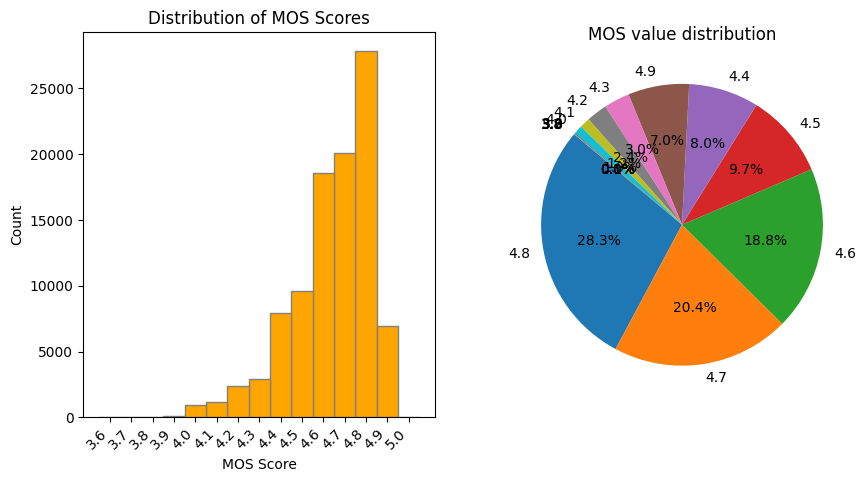

In [15]:
y_dist = df['MOS'].value_counts(normalize=True)
mos_values = df['MOS'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Bar Chart with adjusted spacing
axs[0].bar(mos_values.index, mos_values, edgecolor='gray', color='orange', width=0.1)  # Adjust width for spacing
axs[0].set_xticks(mos_values.index)  # Set x-ticks to align with bars
axs[0].set_xticklabels(mos_values.index, rotation=45, ha='right')  # Rotate labels for better readability
axs[0].set_title('Distribution of MOS Scores')
axs[0].set_xlabel('MOS Score')
axs[0].set_ylabel('Count')

axs[1].pie(y_dist, labels=y_dist.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('MOS value distribution')
plt.show()

## Corrlation Map
Next step in data analysis to understand the correlation between the features. Correlation can be used to reduce dimensionality if the features are correlated strongly. In our data, it's clear that WiFi metrics like "rx/tx bps and rx/tx bps ll" are equivalent. Based on that we drop the following features and drop the feature dimensionality.

* 'bps rx ll'
* 'bps tx ll'
* 'pps rx'
* 'pps tx'
* 'sta_signal'
* 'rx pkts'
* 'tx pkts'

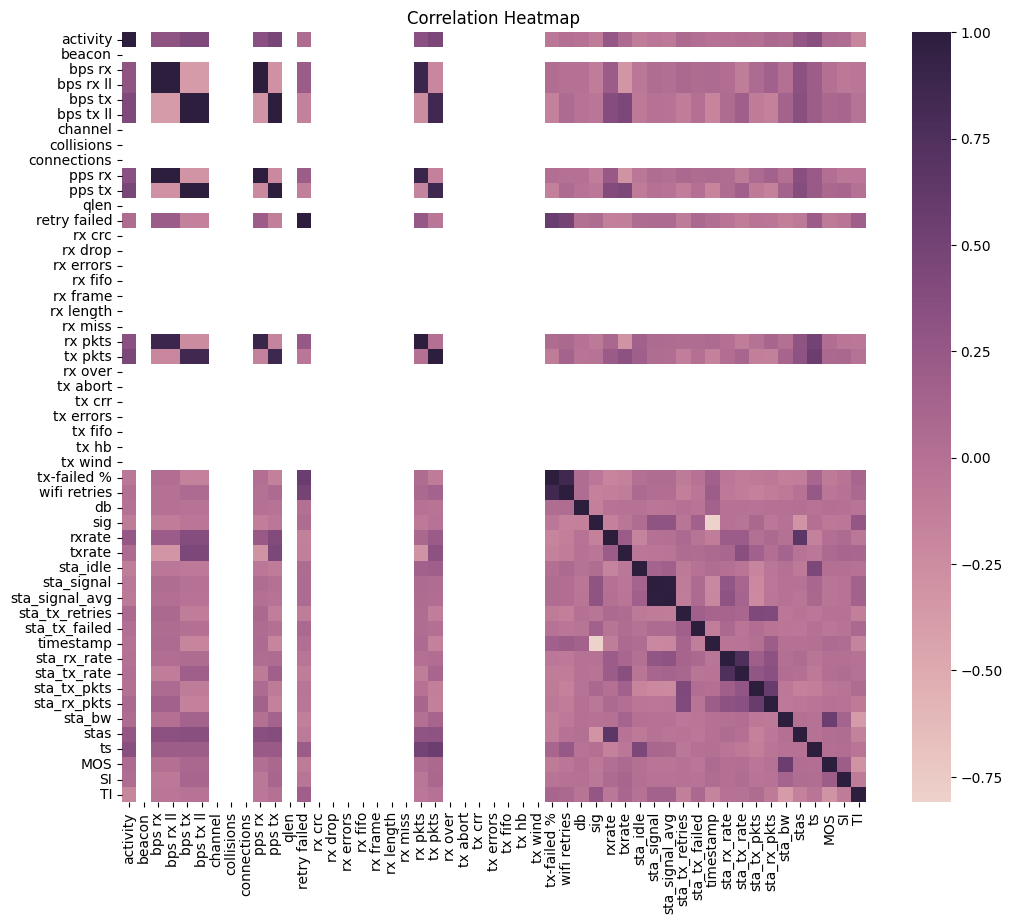

In [31]:
#sample_df = df.sample(n=1000, random_state = 42, replace= False)
corr_matrix = df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))  # Set the figure size
#sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
sns.heatmap(corr_matrix, cmap=sns.cubehelix_palette(as_cmap=True))
#sns.heatmap(corr_matrix,vmax=1,square=True,annot=Frue,cmap='cubehelix')
#sns.heatmap(corr_matrix, cmap='crest')

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

In [32]:

get_correlation(df).head()

bps rx     bps rx ll    1.000000
bps rx ll  bps rx       1.000000
bps tx ll  bps tx       1.000000
bps tx     bps tx ll    1.000000
bps rx     pps rx       0.997599
dtype: float64

In [33]:
df_nodup = df.drop(['bps rx ll', 'bps tx ll', 'pps rx', 'pps tx', 'sta_signal', 'rx pkts', 'tx pkts'], axis = 1)
get_correlation(df_nodup).head(20)

wifi retries  tx-failed %     0.858286
tx-failed %   wifi retries    0.858286
timestamp     sig             0.809371
sig           timestamp       0.809371
sta_tx_rate   sta_rx_rate     0.748090
sta_rx_rate   sta_tx_rate     0.748090
rxrate        stas            0.663123
stas          rxrate          0.663123
sta_tx_pkts   sta_rx_pkts     0.586535
sta_rx_pkts   sta_tx_pkts     0.586535
retry failed  tx-failed %     0.572905
tx-failed %   retry failed    0.572905
MOS           sta_bw          0.561151
sta_bw        MOS             0.561151
wifi retries  retry failed    0.486775
retry failed  wifi retries    0.486775
bps tx        txrate          0.444497
txrate        bps tx          0.444497
sta_idle      ts              0.442784
ts            sta_idle        0.442784
dtype: float64

Here find the features that seem to correlated most to MOS score.

In [34]:
corr_df = get_correlation(df_nodup.drop(['TI', 'SI'], axis = 1))
corr_df['MOS'][:25]

sta_bw            0.561151
bps tx            0.094248
retry failed      0.090231
tx-failed %       0.088743
sig               0.070430
txrate            0.069352
timestamp         0.065502
activity          0.060310
sta_tx_pkts       0.051729
sta_tx_failed     0.051716
wifi retries      0.050005
sta_signal_avg    0.033594
stas              0.031395
sta_tx_rate       0.022487
ts                0.021237
rxrate            0.019989
sta_idle          0.017079
bps rx            0.016236
sta_rx_rate       0.012723
sta_tx_retries    0.010514
sta_rx_pkts       0.007116
db                0.003433
beacon                 NaN
channel                NaN
collisions             NaN
dtype: float64

Correlation Map suggests some pairs of WiFi metrics are correlated.
* (tx-failed %, wifi retries)
* (sta tx rate, sta rx rate)
* (tx failed %, retry failed)
* (activity, bps tx)

In this section we will explore and visualize these relations. We also find the features that are most correlated to MOS score and provide visualizations.

Text(0.5, 1.0, 'WiFi retries Distribution')

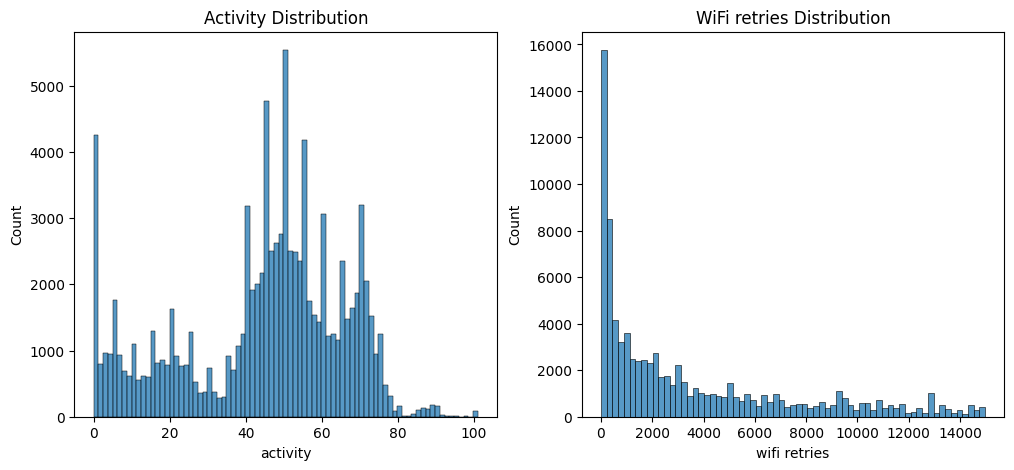

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_nodup['activity'], ax = axes[0])
axes[0].set_title('Activity Distribution')

sns.histplot(df_nodup.query('`wifi retries` < 15000')['wifi retries'], ax = axes[1])
axes[1].set_title('WiFi retries Distribution')

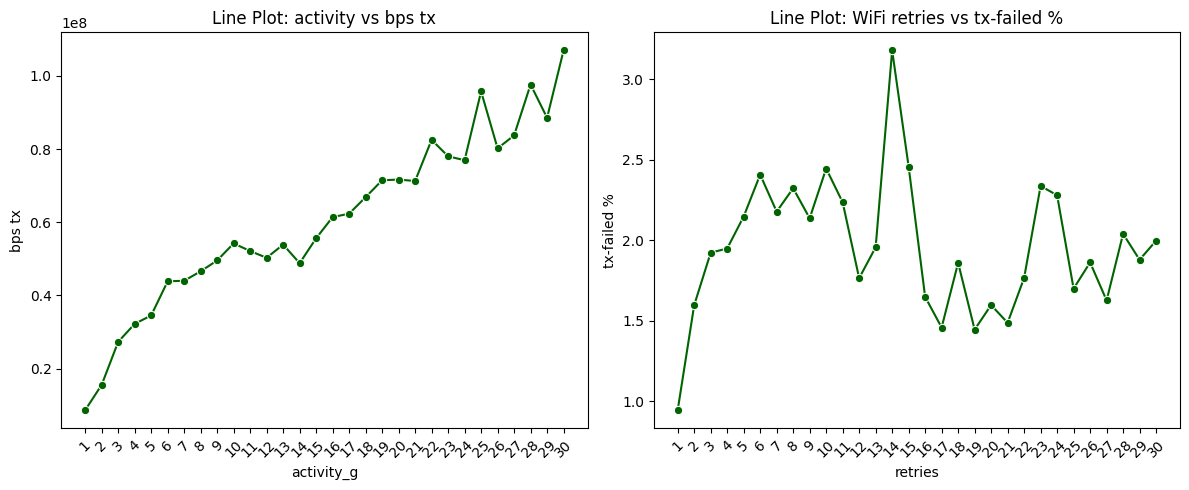

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

filtered_data = df_nodup.query('activity < 75')
bin_edges = np.linspace(filtered_data['activity'].min(), filtered_data['activity'].max(), 31)
filtered_data['activity_g'] = pd.cut(filtered_data['activity'], bins=bin_edges, labels=list(range(1, 31)))
grouped_activity = filtered_data.groupby('activity_g', observed=True)['bps tx'].mean().reset_index()
sns.lineplot(data = grouped_activity, x = 'activity_g', y = 'bps tx', marker='o', color='darkgreen', ax = axes[0])
axes[0].set_xticks(grouped_activity['activity_g'])
axes[0].set_xticklabels(grouped_activity['activity_g'], rotation=45)
#sns.scatterplot(data=filtered_data, x='activity', y='bps tx', ax=axes[0])
axes[0].set_title('Line Plot: activity vs bps tx')

filtered_data = df_nodup.query('`wifi retries` < 20000')
bin_edges = np.linspace(filtered_data['wifi retries'].min(), filtered_data['wifi retries'].max(), 31)
filtered_data['retries'] = pd.cut(filtered_data['wifi retries'], bins=bin_edges, labels=list(range(1, 31)))
grouped_retry = filtered_data.groupby('retries', observed=True)['tx-failed %'].mean().reset_index()
sns.lineplot(data = grouped_retry, x = 'retries', y = 'tx-failed %', marker='o', color='darkgreen', ax = axes[1])
axes[1].set_xticks(grouped_retry['retries'])
axes[1].set_xticklabels(grouped_retry['retries'], rotation=45)
#sns.scatterplot(data=filtered_data, x='wifi retries', y='tx-failed %', ax=axes[1])
axes[1].set_title('Line Plot: WiFi retries vs tx-failed %')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

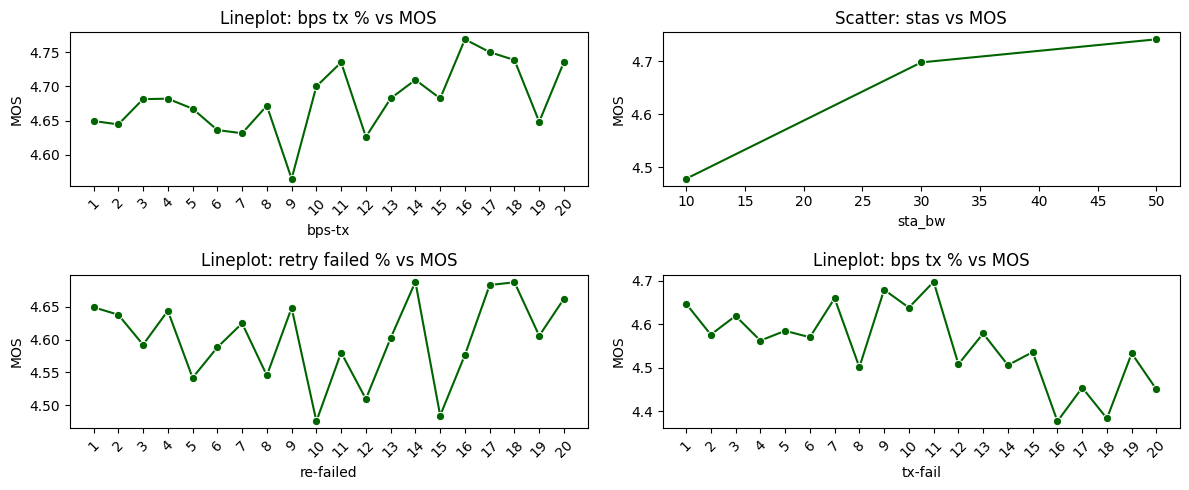

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

filtered_data = df_nodup.query('`bps tx` < 2000')
filtered_data['bps-tx'] = pd.cut(filtered_data['bps tx'], bins=20, labels=list(range(1, 21)))
grouped_retryfailed = filtered_data.groupby('bps-tx', observed=True)['MOS'].mean().reset_index()
sns.lineplot(data=grouped_retryfailed, x='bps-tx', y='MOS', marker='o', color='darkgreen',ax=axes[0, 0])
axes[0, 0].set_xticks(grouped_retryfailed['bps-tx'])
axes[0, 0].set_xticklabels(grouped_retryfailed['bps-tx'], rotation=45)
axes[0, 0].set_title('Lineplot: bps tx % vs MOS')

filtered_data = df_nodup.copy()
grouped_retry = filtered_data.groupby('sta_bw', observed=True)['MOS'].mean().reset_index()
sns.lineplot(data = grouped_retry, x = 'sta_bw', y = 'MOS', marker='o', color='darkgreen', ax = axes[0, 1])
axes[0, 1].set_title('Scatter: stas vs MOS')


filtered_data['re-failed'] = pd.cut(filtered_data['retry failed'], bins=20, labels=list(range(1, 21)))
grouped_retryfailed = filtered_data.groupby('re-failed', observed=True)['MOS'].mean().reset_index()
sns.lineplot(data=grouped_retryfailed, x='re-failed', y='MOS', marker='o', color='darkgreen',ax=axes[1, 0])
axes[1, 0].set_xticks(grouped_retryfailed['re-failed'])
axes[1, 0].set_xticklabels(grouped_retryfailed['re-failed'], rotation=45)
axes[1, 0].set_title('Lineplot: retry failed % vs MOS')


filtered_data['tx-fail'] = pd.cut(filtered_data['tx-failed %'], bins=20, labels=list(range(1, 21)))
grouped_retryfailed = filtered_data.groupby('tx-fail', observed=True)['MOS'].mean().reset_index()
sns.lineplot(data=grouped_retryfailed, x='tx-fail', y='MOS', marker='o', color='darkgreen',ax=axes[1, 1])
axes[1, 1].set_xticks(grouped_retryfailed['tx-fail'])
axes[1, 1].set_xticklabels(grouped_retryfailed['tx-fail'], rotation=45)
axes[1, 1].set_title('Lineplot: bps tx % vs MOS')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Data Preparation
In this step, we explore the Wifi metrics data extraction and cleansing, scaling/normalizing, encoding non-numeric data, aggregate the data. We also explore the feature engineering techinques such as PCA for dimensionality reduction and build clusters to understand the data.
  
### Data Transformation
Wifi metrics data include some categorical data, as well as numerical WiFi metrics. As part of data preprocessing, experiment meta data is embedded into the Wifi metrics to identify the type of testing. The meta data features that are embedded are:

* Direction
* Distance
* Throughput
* Number of virtual STAs

So, the transformations include encoding the categorical features and for the numerical type features, scale the values by Standard Scaler.


In [38]:
categorical_cols = df_nodup.select_dtypes(include=['object']).columns
numerical_cols = df_nodup.select_dtypes(include=['number']).columns

# Define the transformers for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(), categorical_cols),  # Apply OrdinalEncoder to categorical columns
        ('numeric', StandardScaler(), numerical_cols)     # Apply StandardScaler to numerical columns
    ])

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the data
df_transformed = pipeline.fit_transform(df_nodup)

# Convert the transformed data back into a DataFrame with the same column names
df_transformed = pd.DataFrame(df_transformed,
                              columns=categorical_cols.tolist() + numerical_cols.tolist())
df_transformed.head()

,sta_bssid,direction,distance,activity,beacon,bps rx,bps tx,channel,collisions,connections,...,sta_rx_rate,sta_tx_rate,sta_tx_pkts,sta_rx_pkts,sta_bw,stas,ts,MOS,SI,TI
0,1.0,1.0,1.0,-2.054747,0.0,-1.024169,-1.188554,0.0,0.0,0.0,...,0.107205,0.316034,5.048178,1.352181,-1.239756,-1.489726,-1.569005,-2.312008,0.729615,0.850980
1,13.0,1.0,1.0,-2.054747,0.0,-0.903953,-1.121775,0.0,0.0,0.0,...,0.798544,0.754837,0.344114,-0.027668,-1.239756,-1.489726,-1.498215,-1.787370,0.068255,1.159409
2,2.0,1.0,1.0,-2.054747,0.0,-0.903953,-1.121775,0.0,0.0,0.0,...,0.798544,1.045121,1.813546,2.468201,-1.239756,-1.489726,-1.498215,-1.787370,0.068255,1.159409
3,13.0,1.0,1.0,-1.962173,0.0,-0.772284,-1.045241,0.0,0.0,0.0,...,0.798544,1.045121,0.345005,-0.026770,-1.239756,-1.489726,-1.462821,-0.738093,-1.419805,1.244720
4,2.0,1.0,1.0,-1.962173,0.0,-0.772284,-1.045241,0.0,0.0,0.0,...,0.798544,0.754837,1.814406,2.469677,-1.239756,-1.489726,-1.462821,-0.738093,-1.419805,1.244720


In [39]:
df_clean = df_transformed.dropna()
df_clean.shape

(98513, 47)

### Feature Engineering with PCA & Clustering
In this section, we explore dimensionality reduction and explore further in data anlysis if the PCAs can be used effectively for MOS score prediction. We also explore unsupervised learning technique to identify clusters using K-Means clustering.

In [40]:
pca = PCA(n_components=0.98, random_state = 42).fit(df_clean.drop(['MOS'], axis=1))
pca_components = pca.components_

# Convert to DataFrame to see how each feature contributes to each component
pca_loadings = pd.DataFrame(pca_components, columns=df_clean.drop(['MOS'], axis=1).columns)
pca_loadings.head()

,sta_bssid,direction,distance,activity,beacon,bps rx,bps tx,channel,collisions,connections,...,timestamp,sta_rx_rate,sta_tx_rate,sta_tx_pkts,sta_rx_pkts,sta_bw,stas,ts,SI,TI
0,0.993294,-0.000873,-0.002660,0.003520,0.000000e+00,0.002675,0.003651,0.000000e+00,0.000000e+00,0.000000e+00,...,0.009181,-0.008508,-0.019692,-0.077842,-0.052761,-0.001128,0.019206,0.014562,0.002769,-0.007915
1,-0.023907,0.185869,0.128960,-0.144817,0.000000e+00,0.090467,-0.292204,0.000000e+00,0.000000e+00,-4.336809e-19,...,0.086456,-0.220174,-0.291817,-0.119059,-0.124098,-0.111913,-0.204545,0.116450,-0.078070,0.138035
2,0.005616,0.157503,0.037857,0.264460,-2.775558e-17,0.345840,-0.017244,5.551115e-17,-5.551115e-17,1.110223e-16,...,0.411250,0.014520,-0.008329,0.042400,0.178479,0.030718,0.316611,0.102785,0.032759,-0.242735
3,-0.048493,-0.337824,0.197628,0.125838,-5.551115e-17,-0.275499,0.470776,2.775558e-17,-1.214306e-17,-2.775558e-17,...,0.018801,-0.134484,-0.042664,-0.242576,-0.306820,0.063596,0.143499,0.141288,0.103834,0.065251
4,0.025484,-0.039962,0.101559,0.030401,2.775558e-17,0.015107,0.061976,5.551115e-17,-5.551115e-17,1.110223e-16,...,-0.017256,0.470836,0.439780,0.166984,0.247717,-0.175572,-0.049547,0.127031,-0.031531,0.231584


In [41]:
# Sort the columns based on the absolute values in the row
sorted_columns = pca_loadings.loc[0, :].abs().sort_values(ascending=False)
sorted_columns[:10]

sta_bssid         0.993294
sta_tx_pkts       0.077842
sta_rx_pkts       0.052761
sta_signal_avg    0.042933
sta_idle          0.026733
sta_tx_retries    0.022191
sta_tx_rate       0.019692
stas              0.019206
ts                0.014562
rxrate            0.011850
Name: 0, dtype: float64

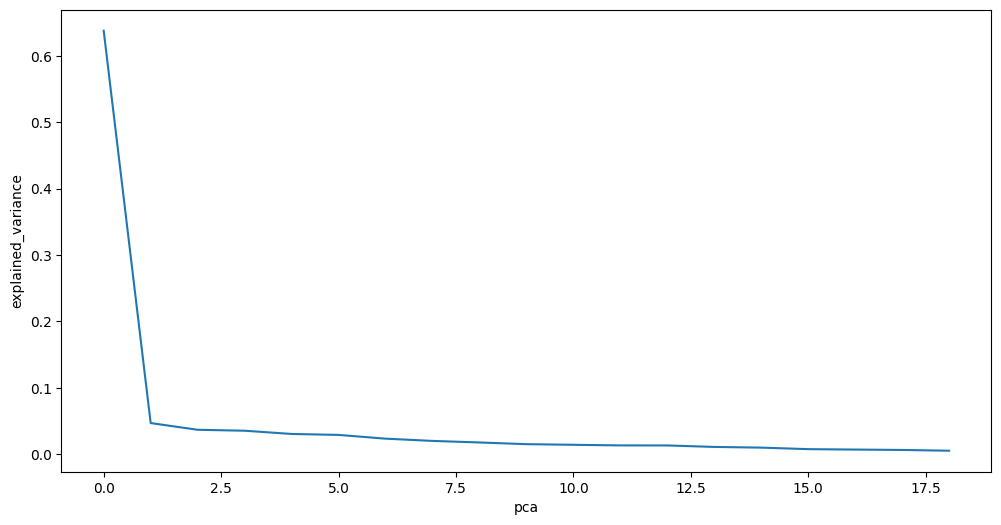

In [42]:
explained_variance_df = pd.DataFrame({'pca': np.arange(len(pca.explained_variance_ratio_)), 'explained_variance': pca.explained_variance_ratio_})
plt.figure(figsize=(12, 6))
sns.lineplot(explained_variance_df, x = 'pca', y= 'explained_variance')
plt.show()

In [43]:
pca = PCA(n_components=0.98, random_state = 42)  # Reducing to 2 components
X_pca = pca.fit_transform(df_clean)

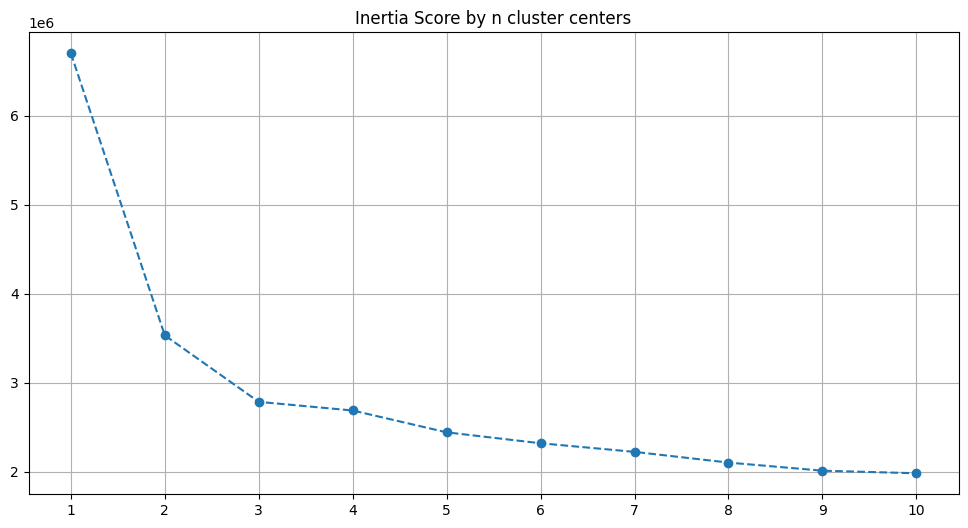

In [44]:
inertias = []
for i in range (1, 11):
    kmeans = KMeans(n_clusters = i, random_state=42).fit(X_pca)
    inertias.append(kmeans.inertia_)
plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(list(range(1, 11)), inertias, '--o')
plt.xticks(list(range(1, 11)), list(range(1, 11)))
plt.title('Inertia Score by n cluster centers');

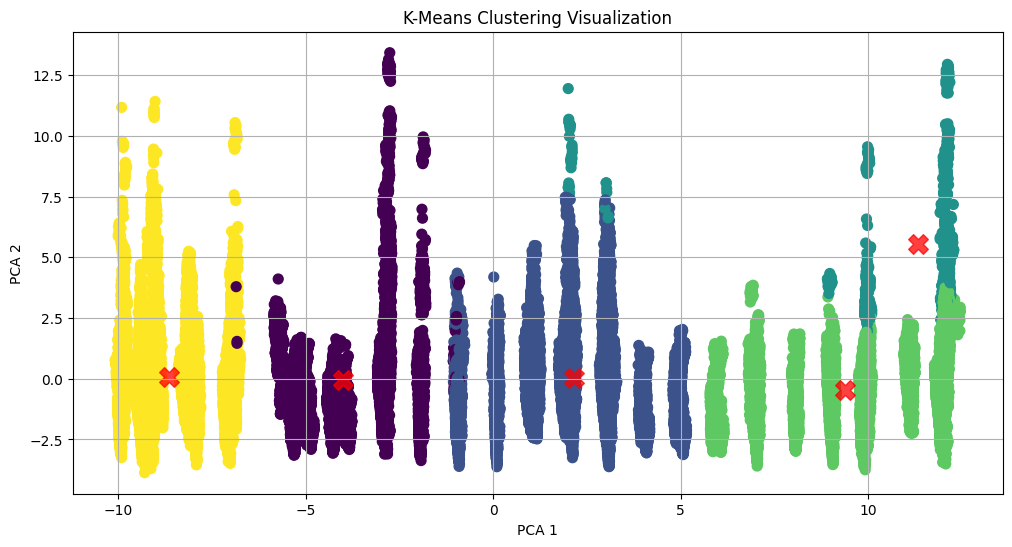

In [45]:
kmeans = KMeans(n_clusters=5)
y_kmeans = kmeans.fit_predict(X_pca)
# Plot the data points and the clusters


# Plot the centroids
centroids = kmeans.cluster_centers_
plt.figure(figsize = (12,6))
plt.grid()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("K-Means Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Data Analysis

Data analysis step includes identify multiple regression models and evaluating the performance and accuracy of these models. For each model that is evaluated, the following KPIs are captured and stored in 'model_kpi_df' data frame.

| Key          | Description                         |
| -------------| ------------------------------------|
| model        | Model Name                          |
| mean_error   | Mean Error                          |
| mean_perror  | Mean Percentage Error               |
| std_error    | Error Stanadard Deviation           |
| std_perror   | Percentage Error Standard Deviation |
| duration     | Duration                            |


In [46]:
model_kpi_df = pd.DataFrame(columns =['model', 'mean_error', 'mean_perror', 'std_error', 'std_perror', 'duration'])
model_kpi_df.head()

,model,mean_error,mean_perror,std_error,std_perror,duration


### Linear Regression with PCA components
The first model we explore for data analysis is Linear regression. Instead of using Wifi metrics as is, we explore if data transformed to PCA components can be used to predict the MOS score and how effective this model to predict the MOS scores.  We use PCA transform method to persist the input data transformations within the model, so that new data can be used as it comes in for MOS score prediction.

## Classifier: LinearRegression() Training Report ##
Training time:  8.669481039047241 seconds
Best Parameters:  {'poly__degree': 2, 'regressor__fit_intercept': True}
Best training Accuracy: 0.9988755629728281
Test Set Accuracy: 0.998864302308859
error mean =  0.03, error std =  0.02
p_error mean = -0.48%, p_error std =  8.98%


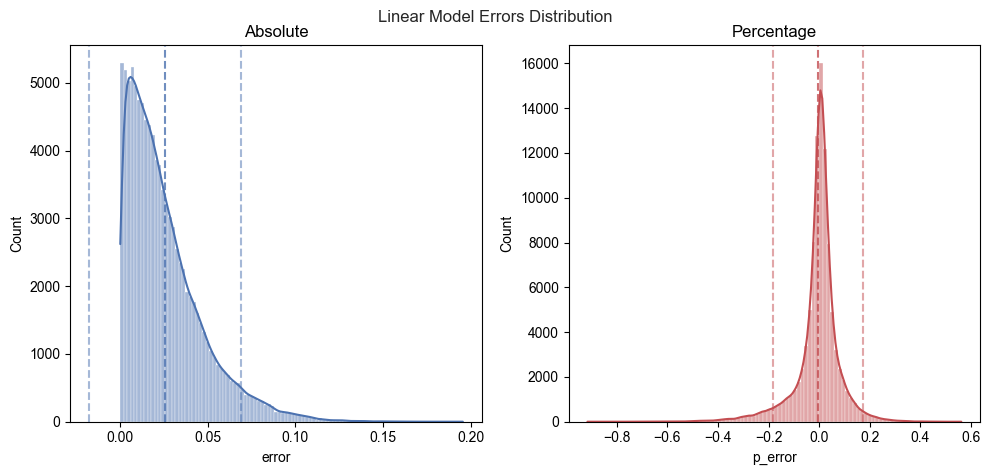

In [48]:
# Apply PCA
pca = PCA(n_components=0.98, random_state = 42)  # Reducing to 2 components
X_pca = pca.fit_transform(df_clean)
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_clean['MOS'], random_state = 42, test_size=.3)

# Define the parameter grid
param_grid = {
    'poly__degree': [1, 2],  # Degrees of polynomial features to try
    'regressor__fit_intercept': [True, False]  # Whether to fit the intercept or not
}

pipe = Pipeline([('poly', PolynomialFeatures(include_bias=False)),
                 ('regressor', LinearRegression())])

grid, duration = train_and_validate_model(pipe, param_grid, X_train, X_test, y_train, y_test)
error_mean, perror_mean, error_std, perror_std = plot_erro_dist(grid, X_train, X_test, y_train, y_test)
model_kpi_df = pd.concat([model_kpi_df, pd.DataFrame({"model": "PCA", "mean_error": error_mean, 
                                                      "mean_perror": perror_mean, 
                                                      "std_error": error_std, 
                                                      "std_perror": perror_std,
                                                      "duration": duration}, index=[0])], ignore_index = True)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(['MOS', 'SI', 'TI'], axis = 1), df_clean['MOS'], 
                                                    random_state = 42, test_size=.3, stratify=df_clean['MOS'])

### Linear Regression
The next model we explore for data analysis is Linear regression. We use Wifi metrics data as is, for training the model. Just as in previous model evaluation, we evalute accuracy and performance of MOS score prediction.

## Classifier: LinearRegression() Training Report ##
Training time:  45.513771772384644 seconds
Best Parameters:  {'poly__degree': 2, 'regressor__fit_intercept': True}
Best training Accuracy: 0.42239031676825045
Test Set Accuracy: 0.41965364262471483
Best Parameters: {'poly__degree': 2, 'regressor__fit_intercept': True}
Best Cross-Validated MSE: -0.42239031676825045
error mean =  0.58, error std =  0.49
p_error mean = -27.48%, p_error std =  156.23%


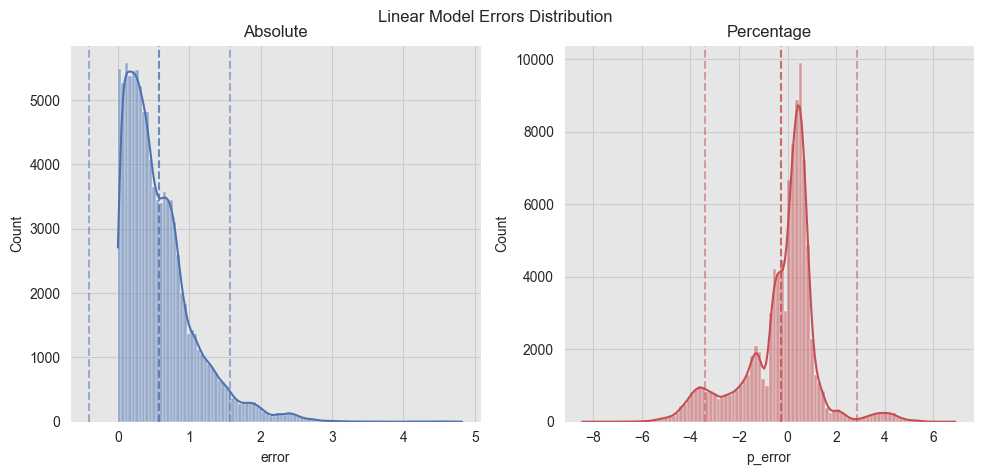

In [50]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1, 2],  # Degrees of polynomial features to try
    'regressor__fit_intercept': [True, False]  # Whether to fit the intercept or not
}

pipe = Pipeline([('poly', PolynomialFeatures(include_bias=False)),
                 ('regressor', LinearRegression())])

grid, duration = train_and_validate_model(pipe, param_grid, X_train, X_test, y_train, y_test)

# Display the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated MSE:", -grid.best_score_)

error_mean, perror_mean, error_std, perror_std = plot_erro_dist(grid, X_train, X_test, y_train, y_test)
model_kpi_df = pd.concat([model_kpi_df, pd.DataFrame({"model": "linear", "mean_error": error_mean, 
                                                      "mean_perror": perror_mean, 
                                                      "std_error": error_std, 
                                                      "std_perror": perror_std,
                                                      "duration": duration}, index=[0])], ignore_index = True)

### Ridge Regression
The next model we explore for data analysis is Ridge regression. We use Wifi metrics data as is, for training the model. Just as in previous model evaluation, we evalute accuracy and performance of MOS score prediction.

## Classifier: Ridge(alpha=0.1) Training Report ##
Training time:  52.40707993507385 seconds
Best Parameters:  {'poly__degree': 2, 'regressor__alpha': 0.1, 'regressor__fit_intercept': True}
Best training Accuracy: 0.42238983309441835
Test Set Accuracy: 0.41963258208764564
Best Parameters: {'poly__degree': 2, 'regressor__alpha': 0.1, 'regressor__fit_intercept': True}
Best Cross-Validated MSE: -0.42238983309441835
error mean =  0.58, error std =  0.49
p_error mean = -27.49%, p_error std =  156.23%


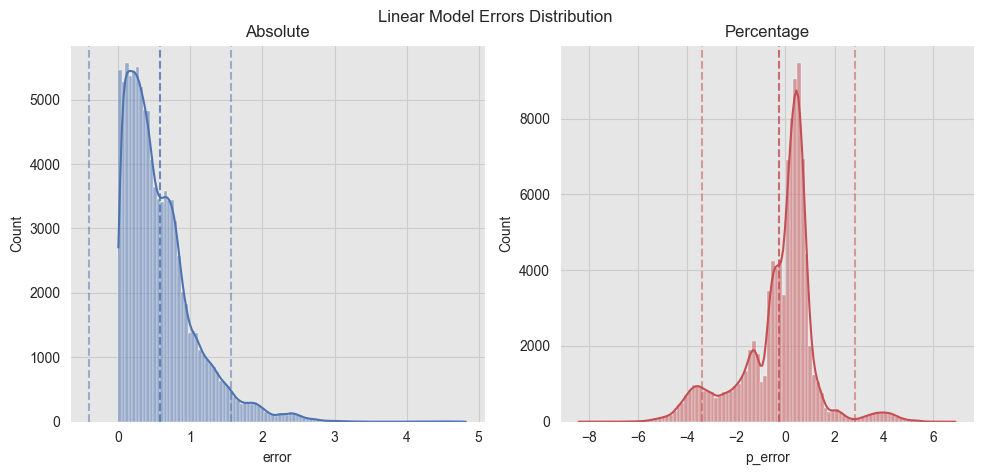

In [51]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1, 2],  # Degrees of polynomial features to try
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
    'regressor__fit_intercept': [True, False]
}

pipe = Pipeline([('poly', PolynomialFeatures(include_bias=False)),
                 ('regressor', Ridge())])

grid, duration = train_and_validate_model(pipe, param_grid, X_train, X_test, y_train, y_test)

# Display the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated MSE:", -grid.best_score_)

error_mean, perror_mean, error_std, perror_std = plot_erro_dist(grid, X_train, X_test, y_train, y_test)
model_kpi_df = pd.concat([model_kpi_df, pd.DataFrame({"model": "ridge", "mean_error": error_mean, 
                                                      "mean_perror": perror_mean, 
                                                      "std_error": error_std, 
                                                      "std_perror": perror_std,
                                                      "duration": duration}, index=[0])], ignore_index = True)

### Lasso Regression
The next model we explore for data analysis is Lasso regression. We use Wifi metrics data as is, for training the model. Just as in previous model evaluation, we evalute accuracy and performance of MOS score prediction.

## Classifier: Lasso(alpha=0.1) Training Report ##
Training time:  61.59651589393616 seconds
Best Parameters:  {'poly__degree': 2, 'regressor__alpha': 0.1, 'regressor__fit_intercept': True}
Best training Accuracy: 0.32934102619345246
Test Set Accuracy: 0.3276700240345298
Best Parameters: {'poly__degree': 2, 'regressor__alpha': 0.1, 'regressor__fit_intercept': True}
Best Cross-Validated MSE: -0.32934102619345246
error mean =  0.64, error std =  0.51
p_error mean = -9.63%, p_error std =  137.82%


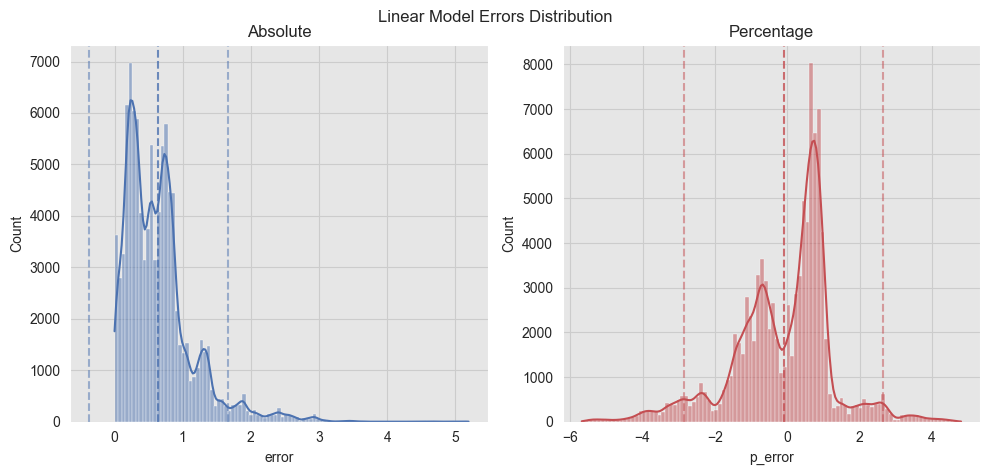

In [52]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1, 2],  # Degrees of polynomial features to try
    'regressor__alpha': [0.1, 0.5, 1.0],
    'regressor__fit_intercept': [True, False]
}

pipe = Pipeline([('poly', PolynomialFeatures(include_bias=False)),
                 ('regressor', Lasso())])

grid, duration = train_and_validate_model(pipe, param_grid, X_train, X_test, y_train, y_test)

# Display the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated MSE:", -grid.best_score_)

error_mean, perror_mean, error_std, perror_std = plot_erro_dist(grid, X_train, X_test, y_train, y_test)
model_kpi_df = pd.concat([model_kpi_df, pd.DataFrame({"model": "lasso", "mean_error": error_mean, 
                                                      "mean_perror": perror_mean, 
                                                      "std_error": error_std, 
                                                      "std_perror": perror_std,
                                                      "duration": duration}, index=[0])], ignore_index = True)

### K-nearest neighbor Regression
The next model we explore for data analysis is K-nearest neighbors regression. We use Wifi metrics data as is, for training the model. Just as in previous model evaluation, we evalute accuracy and performance of MOS score prediction.

## Classifier: KNeighborsRegressor(p=1, weights='distance') Training Report ##
Training time:  271.1343858242035 seconds
Best Parameters:  {'regressor__n_neighbors': 5, 'regressor__p': 1, 'regressor__weights': 'distance'}
Best training Accuracy: 0.5963191609420394
Test Set Accuracy: 0.6086132090882999
Best Parameters: {'regressor__n_neighbors': 5, 'regressor__p': 1, 'regressor__weights': 'distance'}
Best Cross-Validated MSE: -0.5963191609420394
error mean =  0.39, error std =  0.49
p_error mean = -18.98%, p_error std =  139.31%


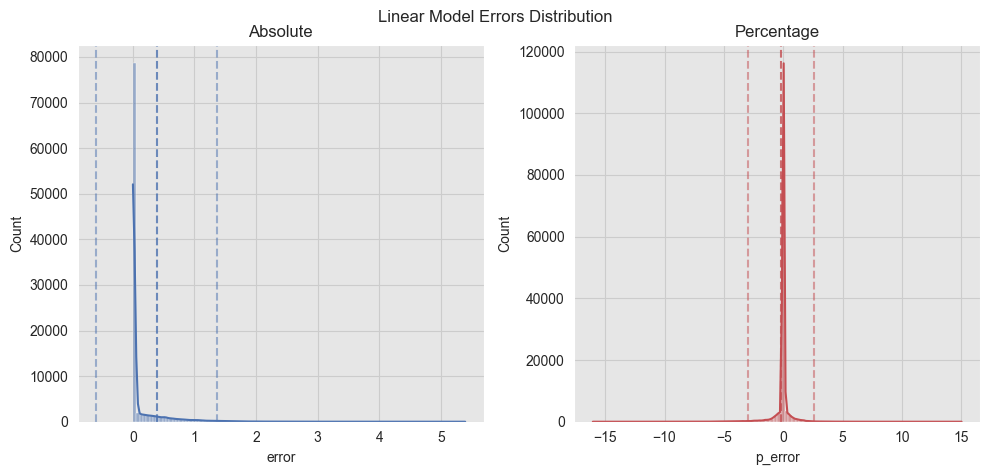

In [53]:
# Define the parameter grid
param_grid = {
    'regressor__n_neighbors': [5, 7, 9],      # Number of neighbors
    'regressor__weights': ['uniform', 'distance'],  # Weighting function
    'regressor__p': [1, 2]  # p=1 for Manhattan, p=2 for Euclidean
}

pipe = Pipeline([('regressor', KNeighborsRegressor())])

grid, duration = train_and_validate_model(pipe, param_grid, X_train, X_test, y_train, y_test)

# Display the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated MSE:", -grid.best_score_)

# Plot the error distribution
error_mean, perror_mean, error_std, perror_std = plot_erro_dist(grid, X_train, X_test, y_train, y_test)
model_kpi_df = pd.concat([model_kpi_df, pd.DataFrame({"model": "knn", "mean_error": error_mean, 
                                                      "mean_perror": perror_mean, 
                                                      "std_error": error_std, 
                                                      "std_perror": perror_std,
                                                      "duration": duration}, index=[0])], ignore_index = True)

### Decision Tree Regression
The next model we explore for data analysis is Decision Tree regression. We use Wifi metrics data as is, for training the model. Just as in previous model evaluation, we evalute accuracy and performance of MOS score prediction. 

## Classifier: DecisionTreeRegressor(max_depth=10, random_state=42) Training Report ##
Training time:  108.65555691719055 seconds
Best Parameters:  {'regressor__max_depth': 10, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best training Accuracy: 0.5944657643926682
Test Set Accuracy: 0.5990119708116548
Best Parameters: {'regressor__max_depth': 10, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best Cross-Validated MSE: -0.5944657643926682
error mean =  0.41, error std =  0.48
p_error mean = -25.41%, p_error std =  137.17%


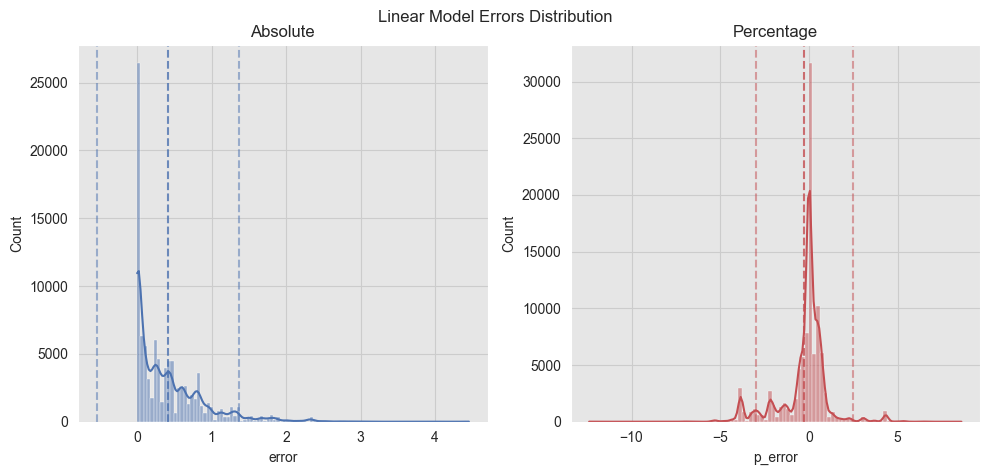

In [54]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__max_depth': [2, 4, 6, 8, 10],         # Maximum depth of the tree
    'regressor__min_samples_split': [2, 5, 10],       # Minimum number of samples to split an internal node
    'regressor__min_samples_leaf': [1, 2, 4],         # Minimum number of samples to be at a leaf node
    'regressor__max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

pipe = Pipeline([('regressor', DecisionTreeRegressor(random_state=42))])
grid, duration = train_and_validate_model(pipe, param_grid, X_train, X_test, y_train, y_test)

# Display the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated MSE:", -grid.best_score_)

error_mean, perror_mean, error_std, perror_std = plot_erro_dist(grid, X_train, X_test, y_train, y_test)
model_kpi_df = pd.concat([model_kpi_df, pd.DataFrame({"model": "dtr", "mean_error": error_mean, 
                                                      "mean_perror": perror_mean, 
                                                      "std_error": error_std, 
                                                      "std_perror": perror_std,
                                                      "duration": duration}, index=[0])], ignore_index = True)

### SVM Regression
The next model we explore for data analysis is SVM regression. We use Wifi metrics data as is, for training the model. Just as in previous model evaluation, we evalute accuracy and performance of MOS score prediction. SVM kernel regression consumes considerable compute, hence we use sampled data, insted of whole data for regression analysis.

In [55]:
df_sample = df_clean.sample(n=5000, random_state = 42, replace= False)
df_sample.shape, df_clean.shape

((5000, 47), (98513, 47))

## Classifier: SVR(C=10, epsilon=0.2) Training Report ##
Training time:  383.9007821083069 seconds
Best Parameters:  {'regressor__C': 10, 'regressor__epsilon': 0.2, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
Best training Accuracy: 0.36525740628206294
Test Set Accuracy: 0.3849863124547691
Best Parameters: {'regressor__C': 10, 'regressor__epsilon': 0.2, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
Best Cross-Validated MSE: -0.36525740628206294
error mean =  0.58, error std =  0.52
p_error mean = -23.26%, p_error std =  140.33%


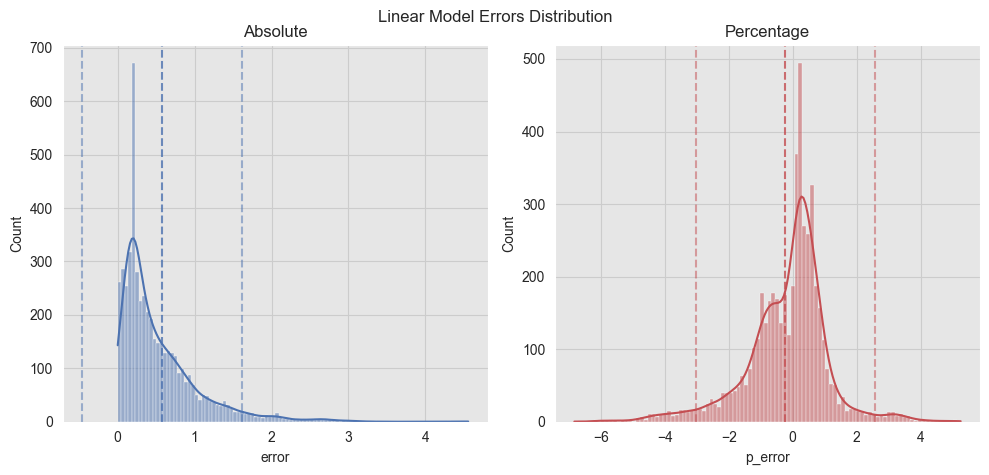

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_sample.drop(['MOS'], axis = 1), df_sample['MOS'], 
                                                    random_state = 42, test_size=.3)

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__C': [0.1, 1, 10],  # Regularization parameter
    'regressor__epsilon': [0.01, 0.1, 0.2],  # Epsilon parameter for the epsilon-insensitive loss function
    'regressor__kernel': ['linear', 'rbf'],  # Kernel type: 'linear' or 'rbf' (Radial Basis Function)
    'regressor__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}

pipe = Pipeline([('regressor', SVR())])

grid, duration = train_and_validate_model(pipe, param_grid, X_train, X_test, y_train, y_test)

# Display the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated MSE:", -grid.best_score_)

error_mean, perror_mean, error_std, perror_std = plot_erro_dist(grid, X_train, X_test, y_train, y_test)
model_kpi_df = pd.concat([model_kpi_df, pd.DataFrame({"model": "svr", "mean_error": error_mean, 
                                                      "mean_perror": perror_mean, 
                                                      "std_error": error_std, 
                                                      "std_perror": perror_std,
                                                      "duration": duration}, index=[0])], ignore_index = True)

In [57]:
model_kpi_df.head()

,model,mean_error,mean_perror,std_error,std_perror,duration
0,PCA,0.025665,-0.004777,0.021768,0.089784,8.669481
1,linear,0.580630,-0.274794,0.493360,1.562329,45.513772
2,ridge,0.580667,-0.274919,0.493338,1.562307,52.407080
3,lasso,0.644111,-0.096332,0.507612,1.378215,61.596516
4,knn,0.388700,-0.189845,0.490336,1.393122,271.134386


# Conclusions
This section summarizes the performance and accuracy scores of all the models that were evaluated. It depicts Mean error, Mean percentage error, Error standard deviation as well as Percentage error standard deviation as bar chart.

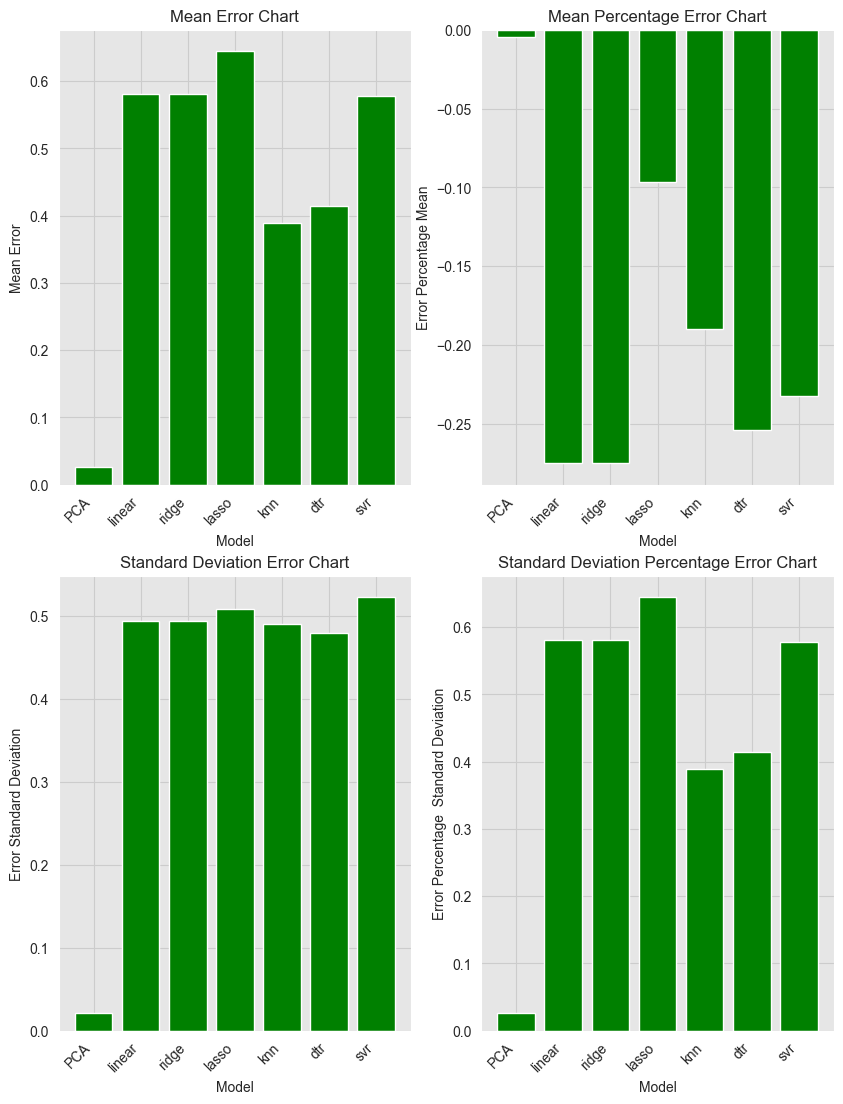

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(10, 13))
# Bar Chart with adjusted spacing
axs[0, 0].bar(model_kpi_df['model'], model_kpi_df['mean_error'], edgecolor='white', color='green')  # Adjust width for spacing
axs[0, 0].set_xticks(model_kpi_df['model'])  # Set x-ticks to align with bars
axs[0, 0].set_xticklabels(model_kpi_df['model'], rotation=45, ha='right')  # Rotate labels for better readability
axs[0, 0].set_title('Mean Error Chart')
axs[0, 0].set_xlabel('Model')
axs[0, 0].set_ylabel('Mean Error')

axs[0, 1].bar(model_kpi_df['model'], model_kpi_df['mean_perror'], edgecolor='white', color='green')  # Adjust width for spacing
axs[0, 1].set_xticks(model_kpi_df['model'])  # Set x-ticks to align with bars
axs[0, 1].set_xticklabels(model_kpi_df['model'], rotation=45, ha='right')  # Rotate labels for better readability
axs[0, 1].set_title('Mean Percentage Error Chart')
axs[0, 1].set_xlabel('Model')
axs[0, 1].set_ylabel('Error Percentage Mean')

axs[1, 0].bar(model_kpi_df['model'], model_kpi_df['std_error'], edgecolor='white', color='green')  # Adjust width for spacing
axs[1, 0].set_xticks(model_kpi_df['model'])  # Set x-ticks to align with bars
axs[1, 0].set_xticklabels(model_kpi_df['model'], rotation=45, ha='right')  # Rotate labels for better readability
axs[1, 0].set_title('Standard Deviation Error Chart')
axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('Error Standard Deviation')

axs[1, 1].bar(model_kpi_df['model'], model_kpi_df['mean_error'], edgecolor='white', color='green')  # Adjust width for spacing
axs[1, 1].set_xticks(model_kpi_df['model'])  # Set x-ticks to align with bars
axs[1, 1].set_xticklabels(model_kpi_df['model'], rotation=45, ha='right')  # Rotate labels for better readability
axs[1, 1].set_title('Standard Deviation Percentage Error Chart')
axs[1, 1].set_xlabel('Model')
axs[1, 1].set_ylabel('Error Percentage  Standard Deviation')
plt.show()

The following diagram depicts the model training duration of each model. 

Text(0, 0.5, 'Duration')

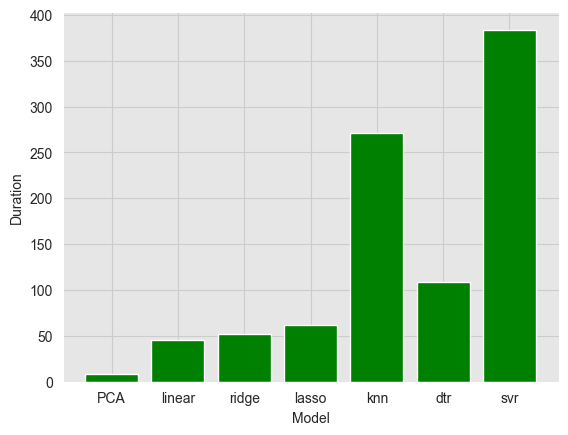

In [61]:
plt.bar(model_kpi_df['model'], model_kpi_df['duration'], edgecolor='white', color='green')
plt.xticks(model_kpi_df['model'])
#plt.xticklabels(model_kpi_df['model'], rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Duration')

# Summary
We can conclude that Linear regression on PCA components provide the best predictiona accuracy. This model also requires the lowest compute power for prediction. Since PCA transformations are embedded in the model, this model can be applied to future data collected and predict the corresponding MOS Score. 